# Exploratory Data Analysis

Instruction
---
Download all the daaset files and put them in home folder of your Google Drive in the folder ML_PW.

List of Content
---

### 1. Class Balance Verification

- Count samples in **Class 0** (Not Allowed) and **Class 1** (Allowed).
- Count how many speakers are male and female in particular groups.
- Generate a **bar chart** showing counts per class.

### 2. Audio Length Analysis

- Calculate the **duration (in seconds)** for every audio file.
- Generate a **histogram** of audio durations.

### 3. Waveform Visualization (Time Domain)

- Plot **Amplitude vs. Time** for random Class 1 samples. | Assess signal quality and structure.
- Plot **Amplitude vs. Time** for random Class 0 samples. | Assess signal quality and structure.
- **Inspect for long periods of silence** at file boundaries.
- **Inspect for signal clipping** (amplitude hitting limits).

### 4. Spectrogram Visualization (Frequency Domain)

- Convert a sample Class 1 audio file to a **Mel-spectrogram**.
- Convert a sample Class 0 audio file to a **Mel-spectrogram**.
- Plot Class 1 and Class 0 spectrograms **side-by-side**.
- **Inspect for background noise** (non-black areas during speech absence).
- Mean spectrograms

### 5. Technical Sanity Checks (Metadata)

- Verify that the **Sample Rate** (e.g., $16kHz$, $44.1kHz$) is **consistent** across all files.
- Verify that the **Channel count** (Mono/Stereo) is **consistent** across all files.

In [ ]:
!pip install pandas seaborn matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import librosa.display

import os
import random
import warnings
import numpy as np
import librosa
import h5py
import yaml
from datetime import datetime
from pydub import AudioSegment
from scipy.signal import butter, lfilter
warnings.filterwarnings("ignore", category=FutureWarning)
SUPPORTED_EXTS = (".wav", ".mp3", ".m4a", ".wma")
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Mounted at /content/drive


##Reading the audio files
Here we iterate through all the subdirectories containing audiofiles and use label.yaml files to register them as rows in the dataframe


In [ ]:
def build_metadata_dataframe(data_root="/content/drive/MyDrive/ML_PW"):
    records = []
    # Walk through directories
    for root, dirs, files in os.walk(data_root):
        if "labels.yaml" in files:
            yaml_path = os.path.join(root, "labels.yaml")

            # Load labels file
            with open(yaml_path, 'r') as f:
                try:
                    labels_map = yaml.safe_load(f)
                    if not labels_map:
                        continue
                except yaml.YAMLError as e:
                    print(f"Error reading {yaml_path}: {e}")
                    continue

            # Process audio files in this directory
            for filename in files:
                if filename.lower().endswith(SUPPORTED_EXTS):
                    filepath = os.path.join(root, filename)
                    # Retrieve metadata from yaml
                    meta = labels_map.get(filename)
                    if meta:
                        # If it's a string format like "(M,True,Name)", parse it manually
                        if isinstance(meta, str) and meta.startswith('(') and meta.endswith(')'):
                            # 1. Remove parentheses
                            clean_meta = meta.strip("()")
                            # 2. Split by comma
                            parts = [p.strip() for p in clean_meta.split(',')]

                            # 3. Extract fields based on position
                            if len(parts) >= 3:
                                gender = parts[0]

                                is_allowed_str = parts[1]
                                label = parts[2]

                                # Convert string "True" to Boolean True
                                is_allowed = is_allowed_str == "True"
                            else:
                                print(f"Warning: malformed metadata string for {filename}: {meta}")
                                continue

                        else:
                            print(f"Warning: Unknown metadata format for {filename}: {meta}")
                            continue


                        # Get duration (fail-safe)
                        try:
                            duration = librosa.get_duration(path=filepath)
                        except Exception:
                            duration = 0

                        records.append({
                            "filepath": filepath,
                            "filename": filename,
                            "gender": gender,
                            "is_allowed": is_allowed,
                            "label": label,
                            "duration": duration
                        })
                    else:
                        # Optional: print if file exists but isn't in yaml
                        # print(f"Warning: {filename} not found in {yaml_path}")
                        pass

    df = pd.DataFrame(records)
    return df
df = build_metadata_dataframe(data_root="/content/drive/MyDrive/ML_PW")
print(df.head())

                                            filepath  \
0  /content/drive/MyDrive/ML_PW/Recordings/michał...   
1  /content/drive/MyDrive/ML_PW/Recordings/michał...   
2  /content/drive/MyDrive/ML_PW/Recordings/michał...   
3  /content/drive/MyDrive/ML_PW/Recordings/michał...   
4  /content/drive/MyDrive/ML_PW/Recordings/michał...   

                     filename gender  is_allowed         label  duration  
0  michał-financial-times.m4a      M        True        Michal     588.8  
1             Onet-michał.m4a      M        True        Michal     142.9  
2        Warsaw-Central-3.m4a      F       False  AlicjaMichal     107.4  
3        Warsaw-Central-4.m4a      F       False  AlicjaMichal     137.2  
4        Warsaw-Central-5.m4a      F       False  AlicjaMichal     127.2  


## 1. Class Balance Verification

This parts shows the proportions of recordings in the dataset for Class 0 and Class 1, as well as gender of in particular groups.

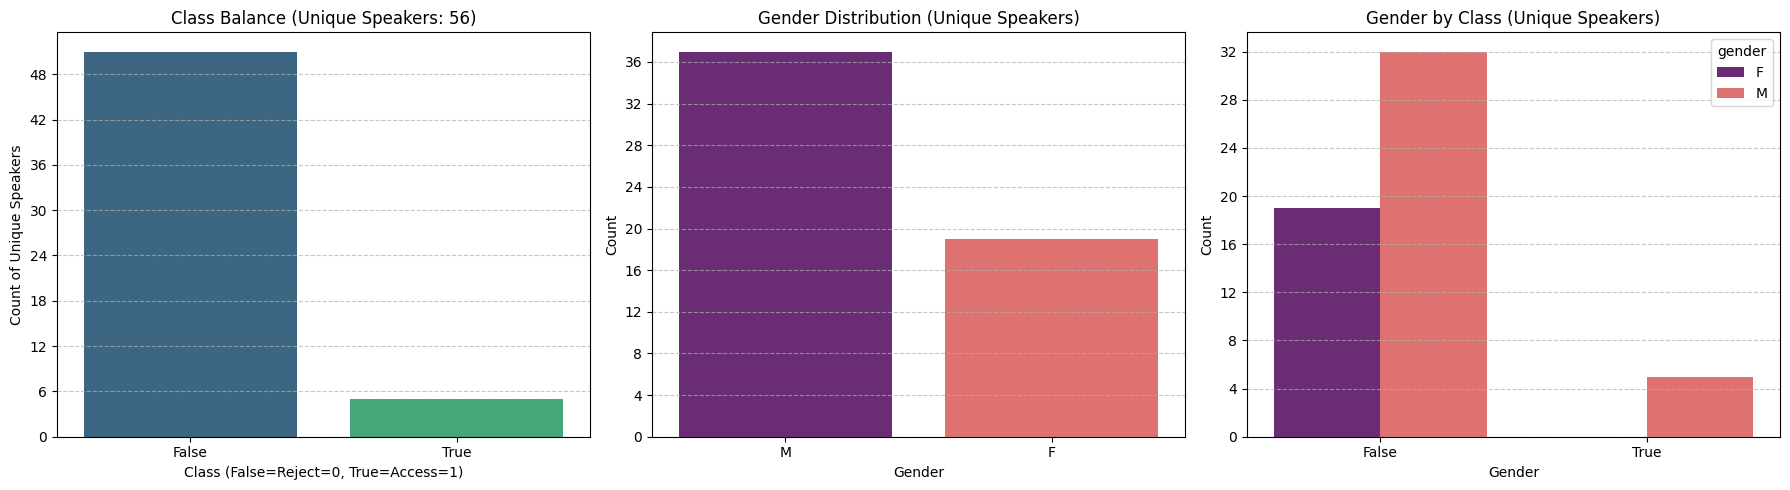

In [ ]:
def plot_distributions(df):
    # 1. Deduplicate based on the unique speaker column ('label')
    # Keep the first occurrence of each speaker to analyze demographic spread
    df_unique = df.drop_duplicates(subset='label').copy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 2. Class Balance (Unique Speakers)
    sns.countplot(x='is_allowed', data=df_unique, ax=axes[0], palette='viridis')
    axes[0].set_title(f"Class Balance (Unique Speakers: {len(df_unique)})")
    axes[0].set_xlabel("Class (False=Reject=0, True=Access=1)")
    axes[0].set_ylabel("Count of Unique Speakers")

    # 3. Gender Distribution (Unique Speakers)
    sns.countplot(x='gender', data=df_unique, ax=axes[1], palette='magma')
    axes[1].set_title("Gender Distribution (Unique Speakers)")
    axes[1].set_xlabel("Gender")
    axes[1].set_ylabel("Count")

    # 4. Gender split by Class (Unique Speakers)
    sns.countplot(x='is_allowed', hue='gender', data=df_unique, ax=axes[2], palette='magma')
    axes[2].set_title("Gender by Class (Unique Speakers)")
    axes[2].set_xlabel("Gender")
    axes[2].set_ylabel("Count")

    # Force integer ticks on Y-axis since we are counting people
    for ax in axes:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Execution
plot_distributions(df)

##2. Audio Length Analysis
The length of audiofiles is not very consistent with a moderately spread distribution and two significant outliers both belonging to Class 1. Generally, most are clustered between 100 and 400 seconds.

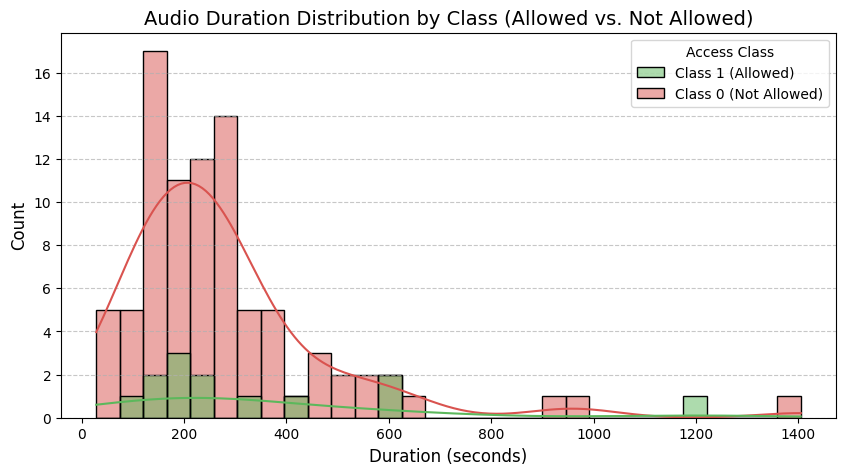


--- Duration Statistics (in seconds) ---
| is_allowed            |   count |    mean |     std |    min |     25% |    50% |     75% |     max |      sum |
|:----------------------|--------:|--------:|--------:|-------:|--------:|-------:|--------:|--------:|---------:|
| Class 0 (Not Allowed) |      88 | 278.123 | 210.496 | 28.5   | 135.6   | 238.17 | 309.15  | 1404.99 | 24474.8  |
| Class 1 (Allowed)     |      13 | 349.981 | 304.869 | 79.804 | 190.634 | 233.3  | 401.986 | 1205.8  |  4549.76 |


In [ ]:
def plot_durations(df):
    """
    Analyzes and plots the distribution of audio file durations
    separated by the access class (0: Not Allowed, 1: Allowed).

    This helps in determining the correct trimming/padding size for CNN inputs.

    Args:
        df (pd.DataFrame): DataFrame containing 'duration' (float) and 'is_allowed' (boolean) columns.
    """

    # Create a categorical column for 'is_allowed' that directly contains the desired legend labels
    df['is_allowed_category'] = df['is_allowed'].map({
        False: 'Class 0 (Not Allowed)',
        True: 'Class 1 (Allowed)'
    })

    # 1. Histogram Plot for Visualization
    plt.figure(figsize=(10, 5))

    sns.histplot(
        data=df,
        x='duration',
        hue='is_allowed_category', # Use the new category for hue
        kde=True,  # Show a smooth curve (KDE) to estimate the underlying distribution
        bins=30,
        palette={'Class 0 (Not Allowed)': '#d9534f', 'Class 1 (Allowed)': '#5cb85c'}, # Palette keys must match the hue values
        legend=True
    )

    plt.title("Audio Duration Distribution by Class (Allowed vs. Not Allowed)", fontsize=14)
    plt.xlabel("Duration (seconds)", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    # The legend is now automatically handled by sns.histplot using the 'is_allowed_category' values
    # We can add a title to the automatically generated legend:
    plt.gca().get_legend().set_title("Access Class")

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # 2. Descriptive Statistics for Documentation (using original 'is_allowed' column)
    print("\n--- Duration Statistics (in seconds) ---")

    # Group by the original 'is_allowed' column (boolean)
    stats = df.groupby('is_allowed')['duration'].describe()

    # Calculate the sum of durations for each class
    sum_durations = df.groupby('is_allowed')['duration'].sum()

    # Add the sum to the stats DataFrame
    stats['sum'] = sum_durations

    # Rename index for clearer output
    stats.rename(index={False: 'Class 0 (Not Allowed)', True: 'Class 1 (Allowed)'}, inplace=True)

    # Print as a nice markdown table
    print(stats.to_markdown())

plot_durations(df)

## 3. Waveform Visualization

Visualizes amplitude for random samples from both classes to evaluate signal structure. Inspection prioritizes identifying long periods of silence at file boundaries and detecting signal clipping. It allows to assess the energy distribution across the file duration.

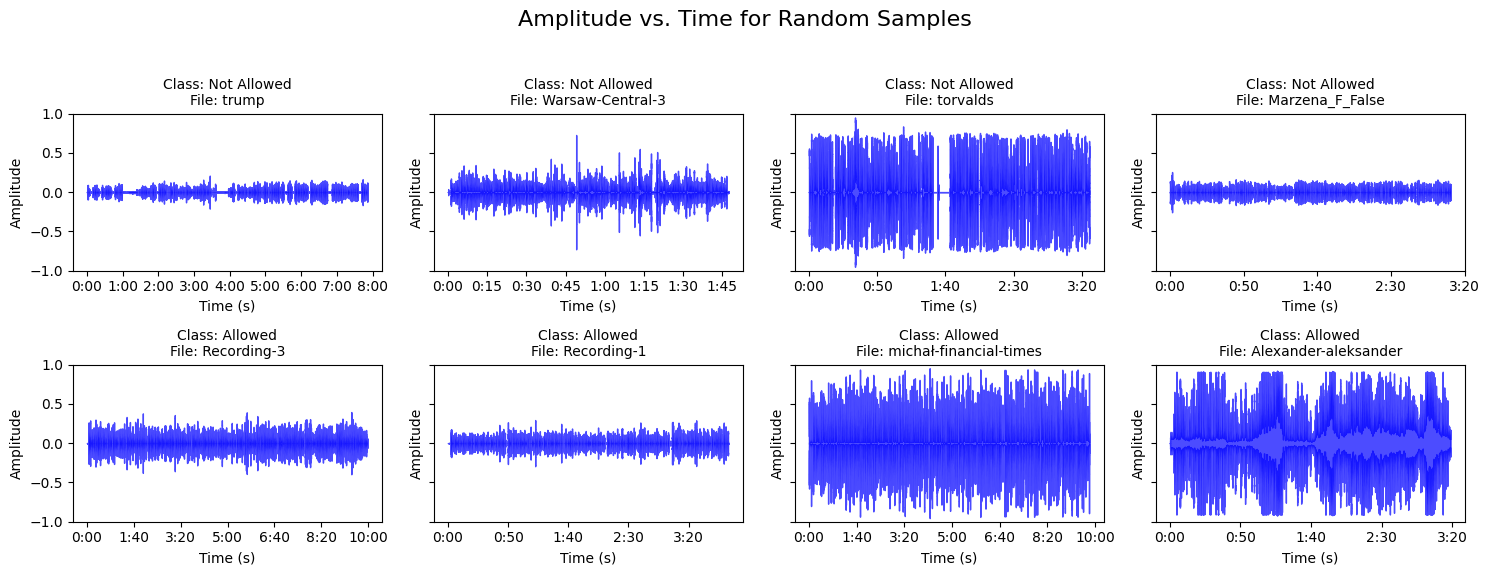

In [ ]:
def plot_amplitude_vs_time(df, n_samples=2):
    """
    Plots amplitude vs. time for n_samples random audio files from each class.
    """
    classes = [0, 1] # 0: Not Allowed, 1: Allowed
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 6), sharex=False, sharey=True)
    fig.suptitle('Amplitude vs. Time for Random Samples', fontsize=16)

    for i, is_allowed_label in enumerate(classes):
        subset = df[df['is_allowed'] == bool(is_allowed_label)]
        class_name = 'Allowed' if is_allowed_label == 1 else 'Not Allowed'

        if len(subset) < n_samples:
            print(f"Not enough samples for class {class_name}. Found {len(subset)}, need {n_samples}.")
            continue

        samples_to_plot = subset.sample(n_samples, random_state=42) # Use random_state for reproducibility

        for j, (_, row) in enumerate(samples_to_plot.iterrows()):
            filepath = row['filepath']
            filename = row['filename']

            try:
                # Load audio using the existing load_audio function
                y, sr = load_audio(filepath, sr=22050) # Use a consistent sample rate

                # Create time axis
                time = np.linspace(0, len(y) / sr, num=len(y))

                ax = axes[i, j] if n_samples > 1 else axes[i]
                librosa.display.waveshow(y, sr=sr, ax=ax, color='blue', alpha=0.7)
                title_text = row['filename'].rsplit('.', 1)[0]
                ax.set_title(f"Class: {class_name}\nFile: {title_text}", fontsize=10)
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Amplitude")
                ax.set_ylim(-1, 1) # Assuming normalized amplitude
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
                ax = axes[i, j] if n_samples > 1 else axes[i]
                ax.set_title(f"Error loading {filename}")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Amplitude")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

# Call the function to plot
plot_amplitude_vs_time(df, n_samples=4)

##Dataset
Below is the method we actually use for creating the spectrograms for our dataset with a suite of preprocessing methods. These functions serve as helpers for further development.

In [ ]:
# ==========================================================
# STEP 0: Load audio file (supports multiple formats)
# ==========================================================
def load_audio(path, sr=22050):
    """
    Load an audio file using pydub, convert it to mono, normalize bit depth,
    and resample it to the target sample rate.

    Args:
        path: Path to the audio file.
        sr: Target sample rate for resampling.

    Returns:
        samples: 1D numpy array of normalized audio samples.
        sr: The final sample rate.
    """
    audio = AudioSegment.from_file(path)

    # Convert stereo to mono if necessary
    if audio.channels > 1:
        audio = audio.set_channels(1)

    # Convert raw audio data to float32 samples
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)
    samples /= (1 << (8 * audio.sample_width - 1))  # Normalize to [-1, 1] range

    # Resample to the target sample rate
    if audio.frame_rate != sr:
        samples = librosa.resample(samples, orig_sr=audio.frame_rate, target_sr=sr)

    return samples, sr


# ==========================================================
# STEP 1: Silence removal
# ==========================================================
def remove_silence(samples, sr, top_db=30):
    """
    Trim silent parts from the start and end of the signal.

    Args:
        samples: Input audio samples.
        sr: Sample rate.
        top_db: Silence threshold in decibels.

    Returns:
        Trimmed audio signal.
    """
    non_silent, _ = librosa.effects.trim(samples, top_db=top_db)
    return non_silent


# ==========================================================
# STEP 2a: Volume normalization
# ==========================================================
def volume_normalize(samples):
    """
    Normalize samples so that the maximum absolute value becomes 1.

    Args:
        samples: Input audio samples.

    Returns:
        Normalized samples.
    """
    max_val = np.max(np.abs(samples)) + 1e-9
    return samples / max_val


# ==========================================================
# STEP 2b: Filtering (band/high/low-pass)
# ==========================================================
def butter_filter(samples, sr, lowcut=None, highcut=None, order=4):
    """
    Apply a Butterworth filter (band-pass, high-pass, or low-pass).

    Args:
        samples: Input audio samples.
        sr: Sample rate.
        lowcut, highcut: Frequency cutoffs.
        order: Filter order.

    Returns:
        Filtered samples.
    """
    nyq = 0.5 * sr  # Nyquist frequency

    # Choose filter type based on which cutoffs are given
    if lowcut and highcut:
        b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")
    elif lowcut:
        b, a = butter(order, lowcut / nyq, btype="high")
    elif highcut:
        b, a = butter(order, highcut / nyq, btype="low")
    else:
        return samples

    return lfilter(b, a, samples)


# ==========================================================
# STEP 3: Split audio into chunks
# ==========================================================
def chunk_audio(samples, sr, chunk_duration=1.0):
    """
    Split the audio into fixed-length chunks. Pads the last chunk if needed.

    Args:
        samples: Input audio samples.
        sr: Sample rate.
        chunk_duration: Duration of each chunk in seconds.

    Returns:
        List of numpy arrays representing chunks.
    """
    chunk_len = int(chunk_duration * sr)
    chunks = []

    for i in range(0, len(samples), chunk_len):
        chunk = samples[i:i + chunk_len]
        if len(chunk) < chunk_len:
            pad = np.zeros(chunk_len, dtype=samples.dtype)
            pad[:len(chunk)] = chunk
            chunk = pad
        chunks.append(chunk)

    return chunks


# ==========================================================
# STEP 4: Convert chunk to log-mel spectrogram
# ==========================================================
def to_logmel(samples, sr, n_mels=64, n_fft=2048, hop_length=512):
    """
    Convert an audio chunk into a log-mel spectrogram.

    Args:
        samples: Audio chunk.
        sr: Sample rate.
        n_mels: Number of mel bands.
        n_fft: FFT window size.
        hop_length: Hop length between frames.

    Returns:
        Log-mel spectrogram (2D numpy array).
    """
    mel = librosa.feature.melspectrogram(y=samples, sr=sr,
                                         n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel.astype(np.float32)


# ==========================================================
# Full audio → list of log-mel chunks
# ==========================================================
def process_audio_to_logmels(
        path, sr=22050,
        remove_silence_flag=True,
        normalize_flag=True,
        filter_flag=False,
        lowcut=None, highcut=None,
        n_mels=64,
        chunk_duration=1.0):
    """
    Apply the entire preprocessing pipeline to one file.

    Steps:
    1. Load and resample audio
    2. Optionally remove silence
    3. Optionally normalize volume
    4. Optionally apply filtering
    5. Split into chunks
    6. Convert chunks to log-mel spectrograms
    """
    samples, sr = load_audio(path, sr)

    if remove_silence_flag:
        samples = remove_silence(samples, sr)
    if normalize_flag:
        samples = volume_normalize(samples)
    if filter_flag:
        samples = butter_filter(samples, sr, lowcut, highcut)

    chunks = chunk_audio(samples, sr, chunk_duration)
    spectrograms = [to_logmel(chunk, sr, n_mels=n_mels) for chunk in chunks]
    return spectrograms

##4. Visualizing The Spectrograms
Below is a method which vizualizes a couple of spectrograms, which are visual representation of an audio signal in which time is on one axis, frequency is on the other axis, and the colour or intensity of each point indicates the amplitude (or power) of that frequency at that moment in time. They're useful for condensing the data contained in an audio file for use by a Neural Net.



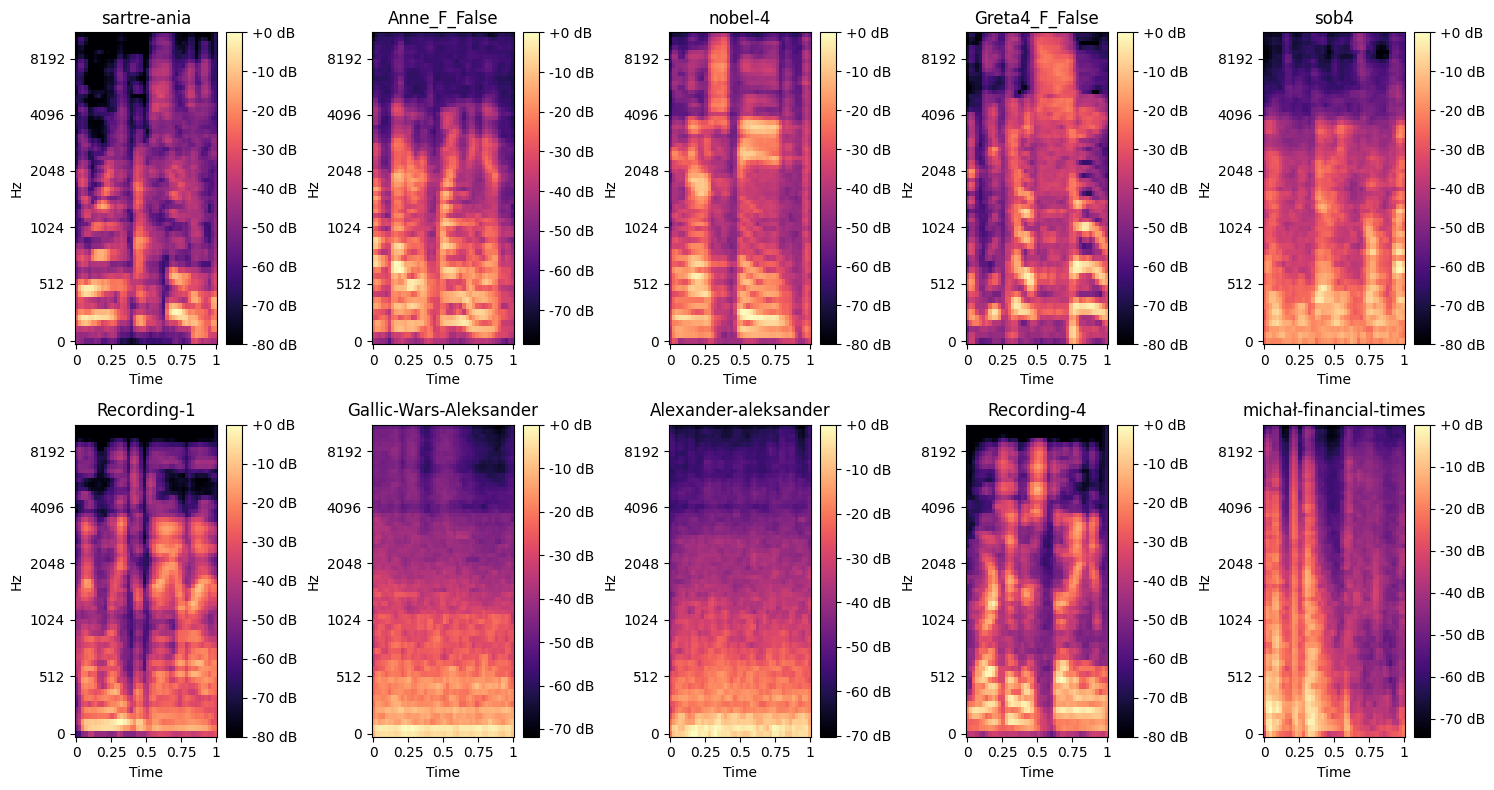

In [ ]:
df['spectrograms'] = df['filepath'].apply(lambda path: process_audio_to_logmels(path, sr=22050))

def visualize_spectrograms(df, n_samples=5):
    """
    Plots n_samples random spectrograms for each class.
    """
    classes = [0, 1]
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 4 * len(classes)))

    for i, label in enumerate(classes):
        # Sample random files
        subset = df[df['is_allowed'] == label]
        if len(subset) < n_samples:
            print(f"Not enough samples for class {label}")
            continue

        samples = subset.sample(n_samples)

        for j, (_, row) in enumerate(samples.iterrows()):

            specs = row['spectrograms']
            if len(specs) > 0:
                ax = axes[i, j]
                img = librosa.display.specshow(specs[0], x_axis='time', y_axis='mel', sr=22050, ax=ax)
                ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
                title_text = row['filename'].rsplit('.', 1)[0]
                ax.set_title(f"{title_text}")
                fig.colorbar(img, ax=ax, format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

visualize_spectrograms(df)

Processing Class 0...
Processing Class 1...


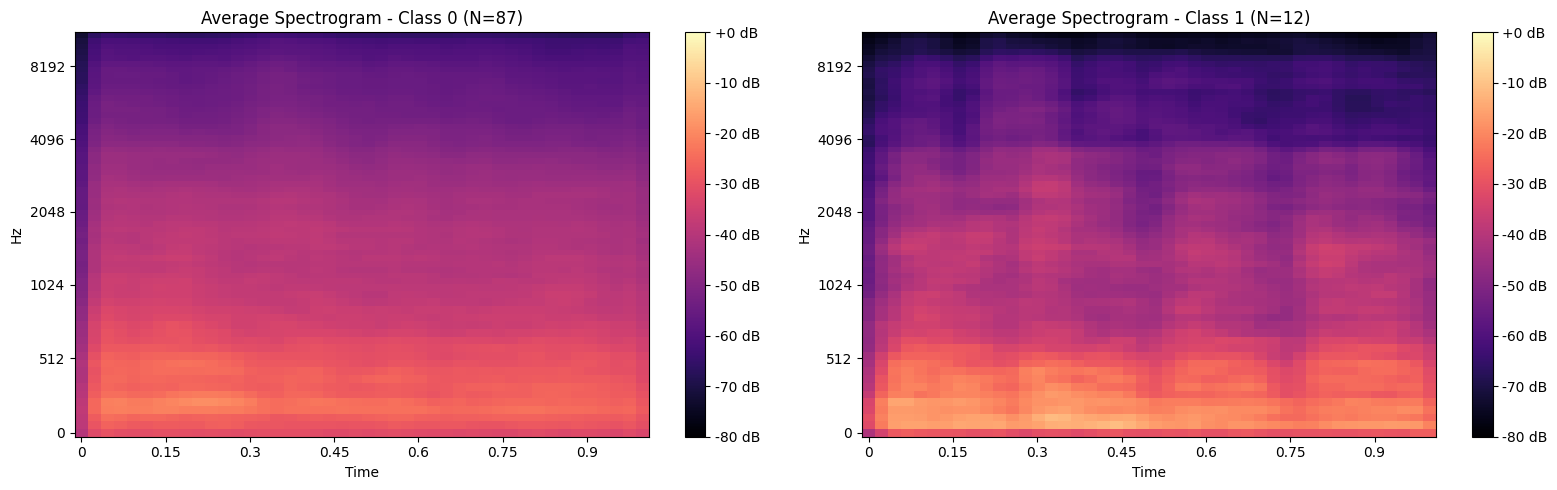

In [ ]:
df['spectrograms'] = df['filepath'].apply(lambda path: process_audio_to_logmels(path, sr=22050))

def plot_mean_spectrograms(df):
    classes = [0, 1]
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for i, label in enumerate(classes):
        subset = df[df['is_allowed'] == label]
        accumulated_spec = None
        count = 0

        print(f"Processing Class {label}...")

        for _, row in subset.iterrows():
            specs = row['spectrograms']
            if specs:
                if accumulated_spec is None:
                    accumulated_spec = specs[0]
                else:
                    # Ensure shape matches before adding
                    if specs[0].shape == accumulated_spec.shape:
                        accumulated_spec += specs[0]
                        count += 1

        if count > 0:
            mean_spec = accumulated_spec / count
            ax = axes[i]
            img = librosa.display.specshow(mean_spec, x_axis='time', y_axis='mel',
                                           sr=22050, ax=ax, vmin=-80, vmax=0)
            ax.set_title(f"Average Spectrogram - Class {label} (N={count})")
            fig.colorbar(img, ax=ax, format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

plot_mean_spectrograms(df)

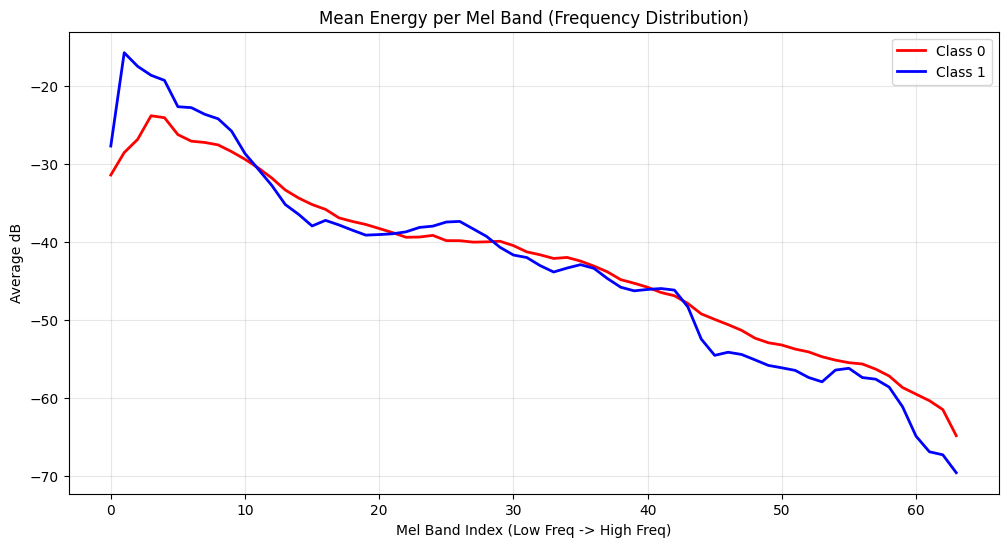

In [ ]:
df['spectrograms'] = df['filepath'].apply(lambda path: process_audio_to_logmels(path, sr=22050))

def plot_frequency_energy(df):
    classes = [0, 1]
    plt.figure(figsize=(12, 6))
    colors = ['red', 'blue']

    for label in classes:
        subset = df[df['is_allowed'] == label]
        energy_per_band = []

        for _, row in subset.iterrows():
            specs = row['spectrograms']
            if specs:
                # Mean energy across time for this sample (collapse columns)
                # resulting shape: (n_mels, )
                sample_energy = np.mean(specs[0], axis=1)
                energy_per_band.append(sample_energy)

        if energy_per_band:
            # Mean across all samples
            # shape: (n_samples, n_mels) -> (n_mels, )
            mean_energy = np.mean(np.array(energy_per_band), axis=0)
            plt.plot(mean_energy, label=f'Class {label}', color=colors[label], linewidth=2)

    plt.title("Mean Energy per Mel Band (Frequency Distribution)")
    plt.xlabel("Mel Band Index (Low Freq -> High Freq)")
    plt.ylabel("Average dB")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_frequency_energy(df)

## 5. Technical Sanity Check
###Data is not consistent in sample rate
As visible in the pie-chart the data is split into multiple different sample rates. We will need to resample them into a single consisten frequency during the dataset creation.
###Data is not consistently mono, or consistently stereo
As visible in the pie-chart the data is split into mono and stereo. During dataset creation we will need to flatten all audiofiles to mono (or stereo, but mono will make the dataset lighter).

/tmp/ipython-input-2436766306.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_loaded = librosa.load(path, sr=None, mono=False)  # do NOT resample, keep native
/tmp/ipython-input-2436766306.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_loaded = librosa.load(path, sr=None, mono=False)  # do NOT resample, keep native
/tmp/ipython-input-2436766306.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_loaded = librosa.load(path, sr=None, mono=False)  # do NOT resample, keep native
/tmp/ipython-input-2436766306.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_loaded = librosa.load(path, sr=None, mono=False)  # do NOT resample, keep native
/tmp/ipython-input-2436766306.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_loaded = librosa.load(path, sr=None, mono=False)  # do NOT resample, keep native
/tmp/ipython-input-2436766306.py:7: UserWarning: PySoundFile failed. Trying audi

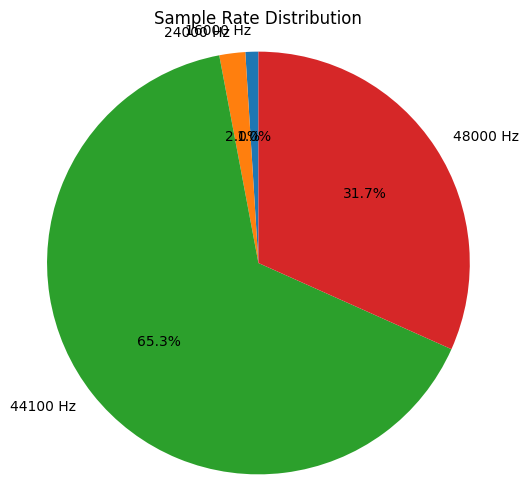

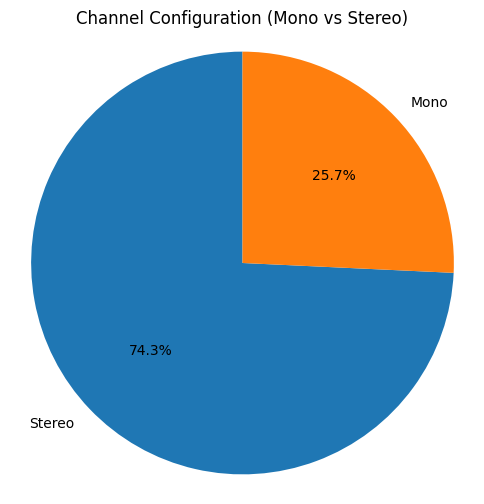

In [ ]:
df = build_metadata_dataframe(data_root="/content/drive/MyDrive/ML_PW")

# --- 1. Enrich df with sample rate + channels info ---
def get_audio_info(path):
    try:
        sr = librosa.get_samplerate(path)
        y, sr_loaded = librosa.load(path, sr=None, mono=False)  # do NOT resample, keep native
        channels = 1 if y.ndim == 1 else y.shape[0]
        return pd.Series({"sample_rate": sr_loaded, "channels": channels})
    except Exception:
        return pd.Series({"sample_rate": None, "channels": None})

df[["sample_rate", "channels"]] = df["filepath"].apply(get_audio_info)
sr_counts = (
    df["sample_rate"]
    .dropna()
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(6, 6))
plt.pie(
    sr_counts.values,
    labels=[f"{int(sr)} Hz" for sr in sr_counts.index],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Sample Rate Distribution")
plt.axis("equal")
plt.show()

# -------- PIE CHART 2: Mono vs Stereo distribution --------

channel_type = df["channels"].map(
    lambda c: "Mono" if c == 1 else ("Stereo" if c == 2 else "Other")
)

chan_counts = channel_type.value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    chan_counts.values,
    labels=chan_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Channel Configuration (Mono vs Stereo)")
plt.axis("equal")
plt.show()